In [0]:
# Imports here
from torch import tensor
from torch import nn
import torchvision
import torch
import torch.nn.functional as F
#from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models
from torch import optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import os, random

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_dir = 'drive/My Drive/Colab Notebooks/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
 
train_transforms = transforms.Compose([transforms.RandomRotation(50),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                     [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir ,transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
vloader = torch.utils.data.DataLoader(validation_data, batch_size =32,shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle = True)

data_transforms = [train_transforms,validation_transforms,test_transforms,]
image_datasets = [train_data,validation_data,test_data]
dataloaders = [trainloader, vloader, testloader]

In [0]:
import json

with open('drive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
# TODO: Build and train your network
# Loading pretrained model - VGG 19
model = models.vgg19(pretrained=True)


for param in model.parameters():
    param.requires_grad = False

In [0]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1024)),
                          ('drop', nn.Dropout(p=0.5)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [0]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

epochs = 5
steps = 0
cuda = torch.cuda.is_available()

if cuda:
    model.cuda()
else:
    model.cpu()
    
running_loss = 0
accuracy = 0

print('Training starts...')

for e in range(epochs):
    
    train_mode = 0
    valid_mode = 1
    
    for mode in [train_mode, valid_mode]:   
        if mode == train_mode:
            model.train()
        else:
            model.eval()
            
        pass_count = 0

        for data in dataloaders[mode]:
            pass_count += 1
            steps += 1
            inputs, labels = data
            if cuda == True:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()
            # Forward
            output = model.forward(inputs.cuda())
            
            loss = criterion(output, labels)
            # Backward
            if mode == train_mode:
                loss.backward()
                optimizer.step()                

            running_loss += loss.item()
            ps = torch.exp(output).data
            equality = (labels.data == ps.max(1)[1])
            accuracy = equality.type_as(torch.FloatTensor()).mean()

        if mode == train_mode:
            
            print("\nEpoch: {}/{} ".format(e+1, epochs),
                  "\nTraining Loss: {:.4f}  ".format(running_loss/pass_count))
        else:
            print("Validation Loss: {:.4f}  ".format(running_loss/pass_count),
            "Accuracy: {:.4f}".format(accuracy))

        running_loss = 0
                

Training starts...

Epoch: 1/5  
Training Loss: 3.8971  
Validation Loss: 2.7100   Accuracy: 0.2222

Epoch: 2/5  
Training Loss: 2.7207  
Validation Loss: 1.8032   Accuracy: 0.6667

Epoch: 3/5  
Training Loss: 2.0995  
Validation Loss: 1.2248   Accuracy: 0.6667

Epoch: 4/5  
Training Loss: 1.7210  
Validation Loss: 1.0034   Accuracy: 0.8889

Epoch: 5/5  
Training Loss: 1.4545  
Validation Loss: 0.8354   Accuracy: 0.8889


In [0]:
# TODO: Do validation on the test set

model.eval()
accuracy = 0
cuda = torch.cuda.is_available()

if cuda:
    model.cuda()
else:
    model.cpu()
    
pass_count = 0

for data in dataloaders[2]:
    pass_count += 1
    images, labels = data
    
    if cuda == True:
        images, labels = Variable(images.cuda()), Variable(labels.cuda())
    else:
        images, labels = Variable(images), Variable(labels)

    output = model.forward(images.cuda())
    prob = torch.exp(output).data
    equality = (labels.data == prob.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

print("Testing Accuracy: {:.4f}".format(accuracy/pass_count))

Testing Accuracy: 0.7667


In [0]:
# TODO: Save the checkpoint 

model.class_to_idx = image_datasets[0].class_to_idx

checkpoint = {'input_size': 25088,
              'output_size': 102,
              'model': 'vgg19',
              'learning_rate': 0.01,
              'batch_size': 64,
              'classifier' : classifier,
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx}

torch.save(checkpoint, 'checkpoint.pth')



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    learning_rate = checkpoint['learning_rate']
    model = getattr(torchvision.models, checkpoint['model'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.epochs = checkpoint['epochs']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer.load_state_dict(checkpoint['optimizer'])
        
    return model

In [0]:
filename = 'checkpoint.pth'

model = load_checkpoint(filename)



In [0]:


def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    img_pil = Image.open(image)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor
    
    


img = (data_dir + '/test' + '/1/' + 'image_06752.jpg')
img = process_image(img)




In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    model.eval()

    # Process the image
    img_torch = process_image(image_path)
    
    # Convert to tensor
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    # The image becomes the input
    
    cuda = torch.cuda.is_available()

    if cuda:
      model.cuda()
    else:
      model.cpu()
    
    if cuda:
        with torch.no_grad():
            output = model.forward(img_torch.cuda())
    else:
        with torch.no_grad():
            output=model.forward(img_torch)
        
   
    probabilities = torch.exp(output).data  

    prob = torch.topk(probabilities, topk)[0].tolist()[0] # probabilities
    index = torch.topk(probabilities, topk)[1].tolist()[0] # index
    
    ind = []
    for i in range(len(model.class_to_idx.items())):
        ind.append(list(model.class_to_idx.items())[i][0])

    # transfer index to label
    label = []
    for i in range(5):
        label.append(ind[index[i]])

    return prob, label

[0.8045964241027832, 0.03529050946235657, 0.023154495283961296, 0.010630629025399685, 0.008985137566924095]
['25', '94', '9', '22', '38']
['grape hyacinth', 'foxglove', 'monkshood', 'pincushion flower', 'great masterwort']


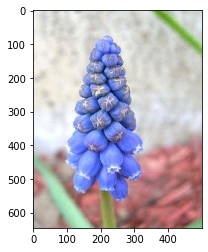

In [0]:
img = random.choice(os.listdir('drive/My Drive/Colab Notebooks/flower_data/test/25/'))
img_path = 'drive/My Drive/Colab Notebooks/flower_data/test/25/' + img
with  Image.open(img_path) as image:
    plt.imshow(image)
    
prob, classes = predict(img_path, model)
print(prob)
print(classes)
print([cat_to_name[x] for x in classes])

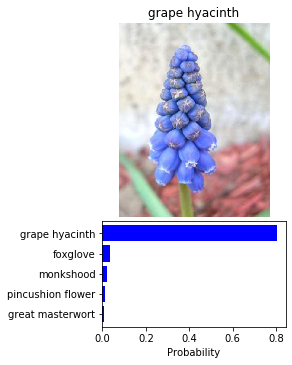

In [0]:
# TODO: Sanity Checking (Display an image along with the top 5 classes)
prob, classes = predict(img_path, model)
max_index = np.argmax(prob)
max_probability = prob[max_index]
label = classes[max_index]

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

image = Image.open(img_path)
ax1.axis('off')
ax1.set_title(cat_to_name[label])
ax1.imshow(image)

labels = []
for cl in classes:
    labels.append(cat_to_name[cl])
    
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, prob, xerr=0, align='center', color='blue')

plt.show()